In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.datasets import fetch_openml  # load_digits

In [2]:
#классификаторы
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC  # Support Vector Machine
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

In [3]:
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV

In [4]:
mnist = fetch_openml('mnist_784')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
pd.DataFrame(mnist.data).head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
X,y= mnist["data"],mnist["target"]
print(X.shape,y.shape)

(70000, 784) (70000,)


In [7]:
pd.DataFrame(mnist.target).head()

,class
0,5
1,0
2,4
3,1
4,9


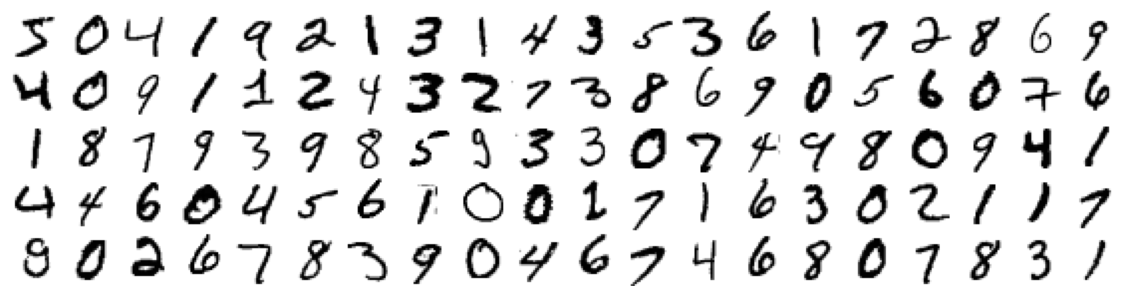

In [8]:
def showDigits(instances, images_per_row=20):
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(28,28) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((28, 28 * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary)
    plt.axis("off")

plt.figure(figsize=(20,10))
example_images = X[:100].values  #таким действием откидываем header
showDigits(example_images)
plt.show()

## Data scaling
масштабирование методом MinMax
$X = \frac{X - X_{min}}{X_{max}-X_{min}}$

In [9]:
from sklearn import preprocessing
size = 20000
scaler = preprocessing.MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)
trainX, testX, trainY, testY = X_scaled[:size], X_scaled[60000:65000], y[:size].values, y[60000:65000].values
print(X_scaled.shape)

(70000, 784)


#Training

**Logistic Regression**

Логичтическая регрессия является частным случаем линейного классификатора.

Линейная регрессия дает предсказание в виде вероятности пренадлежности элемента
к тому или иному классу. 

Вид классической линейной регресси: $y = \beta_0 + \beta_1x_1 + ... \beta_nx_{n-1}$

где $y$ - зависимая перменная, $x_0, ..., x_{n-1}$ - предикторы

В качестве функции активации применяется сигмоидная функция:

$𝛔=\frac{1}{1 + e^{\beta_0 + \beta_1x_1 + ... \beta_nx_{n-1}}}$

В основании предсказания линейной регрессии лежит метод максимизации правдоподобия (MLE) - который определяет параметры, при которых желаемых исход произойдет с максимальной вероятностью.

log-likelihood, log-loss, Логарифм прадоподобия $L(w) = -Σln(P(y_i|x_i, w)) -> max$ Это мы максимизируем.

А задача ставится как минимизация эмпирического риска:
$Q(w) = -Σln(P(y_i|x_i, w)) = Σln(1 + exp(-y_i|xi, w)$




In [10]:
lrg_model = LogisticRegression(max_iter=1000, random_state=42)  # multi_class='ovr'
lrg_model.fit(trainX, trainY)
prediction_lrg = lrg_model.predict(testX)
lrg_accuracy = accuracy_score(testY, prediction_lrg)
print(f' accuracy = {lrg_accuracy}')

KeyboardInterrupt: ignored

**Decision Tree**

\Дерево решений

1. Выбираем элемент для разбиения. Можно выбрать  с помощью индекса Джини $Q = 1 - \sum_0^n p_i^2\$ - считаем вероятности по всем классам в срезе. Или с помощбю энтропии: $H = -∑_0^n\frac{N_i}{N}log\frac{N_i}{N}$ - так же суммируем по всем классам в срезе, если все элементы одного класса - логарифм дает 0

2. Нужно задать критерий остановки: это может быть достигнутая точность, ограничение на глубину дерева и минимального кол-во листьев.

3. Прирост информации, или Information Gane (IG), определяется как уменьшении энтропии. Тогда $IG = S_0 - \sum\frac{N_i}{N}S_i $, где $i$ - номер выборки из разбиения. Таким образом выбирается такое разбиение, в котором достигается максимум прироста информации.

In [ ]:
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth = 15, random_state=17)  # max_depth=3,
decision_tree.fit(trainX, trainY)
prediction_dtree = decision_tree.predict(testX)
des_tree_accuracy = accuracy_score(testY, prediction_dtree)
print(f' accuracy = {des_tree_accuracy}')

$H=-\sum\frac{N_i}{N}log(\frac{N_i}{N})$

$IG = S_0 - \sum N_i/N *S_i = S_0 - N_l/N * S_l - N_r/N * S_r $

1, 7 - опорные вектора из соответствующих классов из MNIST - значит это два изображения очень пожих по написанию 1 и 7

**Random Forest**

In [ ]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
forest.fit(trainX, trainY)
forest_accuracy = accuracy_score(testY, forest.predict(testX))
print(f' accuracy = {forest_accuracy}')

**Support Vector Machine**

In [ ]:
svm = LinearSVC(random_state = 17, max_iter = 10000)
svm.fit(trainX, trainY)
svm_accuracy = accuracy_score(testY, svm.predict(testX))
print(f' accuracy = {svm_accuracy}')

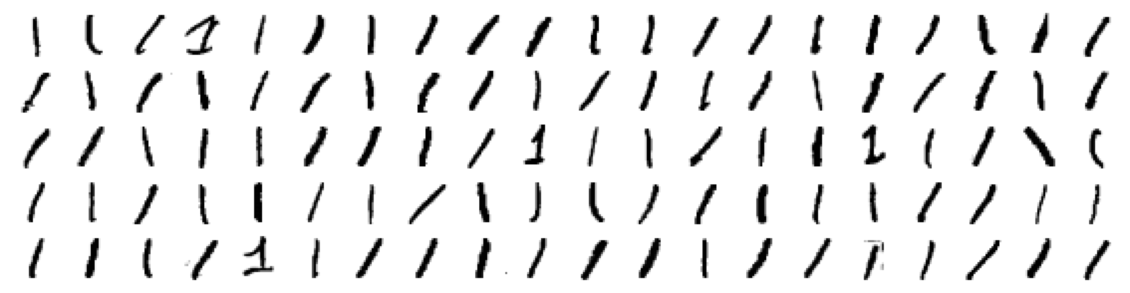

In [13]:
# выбираем только элементы классов "1" и "7"

train_x = np.vstack((trainX[trainY == '1'], trainX[trainY == '7'])) 
train_y = np.hstack([np.ones(len(trainX[trainY == '1'])), np.zeros(len(trainX[trainY == '7'])) - 1])
test_x = np.vstack((testX[testY == '1'], testX[testY == '7'])) 
test_y = np.hstack([np.ones(len(testX[testY == '1'])), np.zeros(len(testX[testY == '7'])) - 1])
plt.figure(figsize=(20,10))
np.random.seed(22)
indexes = np.random.permutation(100)
images = np.array([train_x[index] for index in indexes])
showDigits(images)
plt.show()

 accuracy = 0.987072945521699


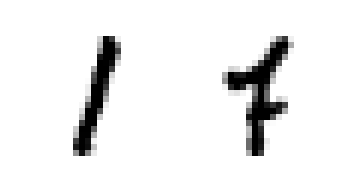

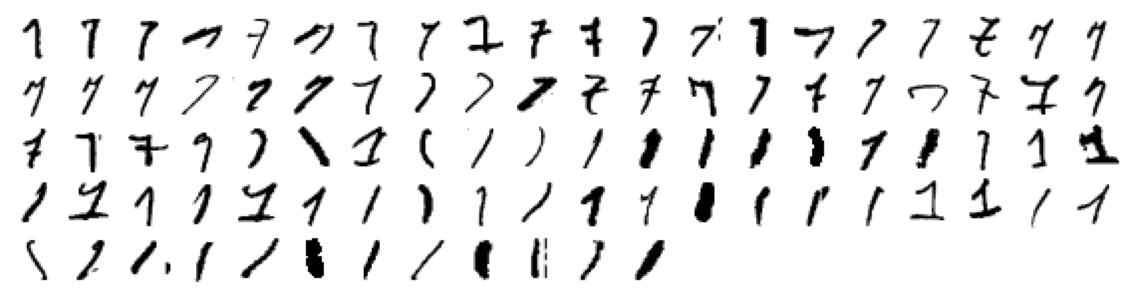

In [14]:
svm_17 = LinearSVC(random_state = 17, max_iter = 10000)
svm_17.fit(train_x, train_y)
svm_17_accuracy = accuracy_score(test_y, svm_17.predict(test_x))
print(f' accuracy = {svm_17_accuracy}')
ind0 = np.argmin(np.abs(svm_17.decision_function(train_x[train_y==-1]) - 1))  # семерка, которая больше всего похожа на 1
ind1 = np.argmin(np.abs(svm_17.decision_function(train_x[train_y==1]) - 1))  # единица, которая боьлше всего похожа на 1
w = svm_17.coef_
indexes = []
for i in range(len(train_x)):
    summ = np.sum(train_x[i] * w)
    if summ >= 1. and summ <= 1.006:
        indexes.append(train_x[i])
    if summ <= -1 and summ >= -1.02:
        indexes.append(train_x[i])
showDigits(np.array(indexes)) # сначала 1, потом 7
plt.show()
plt.close()
from sklearn import svm
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(train_x, train_y)
# indexes = clf.support_
plt.figure(figsize=(20,10))
images = np.array([train_x[index] for index in clf.support_])
showDigits(images)
plt.show()
# print(indexes)

Поиск опорных векторов, если известна нормал $w$ к разделяющей гиперплоскости.

уравнение самой разделяющей плоскости тоже известно $w*x - b = 0$

тогда опорные вектора $x_i$, $x_j$ должны удовлетворять условию:
$w*x_i - b = 1$ и $w*x_j - b = -1$ - пробегаемся по всему датасету перемножая все элементы с w и выбираем два таких элемента, удовлетворяющих вышеизложенным условиям.

**KNN**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(trainX, trainY)
knn_prediction = knn.predict(testX)
knn_accuracy = accuracy_score(testY, knn_prediction)
print(f'accuracy = {knn_accuracy}')

###LogReg with SGD

Пусть w - вектор весов, который задает разделяющую гиперплоскость (w*x)=0

SGD - метод стохастического градиента, на каждом шаге мы делаем градиентный шаг только вдоль одной из осей.

Алгоритм:
1. инициализируем матрицу весов случайным способом
2. начальное вычисление функционала качества Q = \frac{1}{l}∑L(w)
3. цикл
4. случайный выбор наблюдения х_к из Х^l
5. вычисление функции потерь ℇ_k = L_k(w) 
6. шаг псевдоградиенто алгоритма: w = w - \nu gradient[L_k(w)]
7. пересчет функционала качества: Q = λℇ_k + (1-λ)Q, где можно положить λ=2/(N+1)

$w_{t+1}=w_t - Σ\frac{d Loss_i}{dw_i}$

$Loss_i = -(Ylog(p) + (1-p)log(1-p))$

$p = sigma(xw)$

$\frac{dsigma}{dw} = sigma(1-sigma) -> dp = p(1-p)$

$\frac{dLoss_i}{dp} = -(\frac{y}{p} - \frac{1-y}{1-p})dp = -(\frac{y(1-p) + (y-1)p}{p(1-p)})p(1-p) = p - y$

$x_{n𝚇m} * w_{m𝚇1} = A_{n𝚇1} $

$sigma(A_{n𝚇1}) - Y_{n𝚇1} = B_{n𝚇1}$

$x^{T}_{m𝚇n} * B_{n𝚇1} = dw_{m𝚇1}$

In [45]:
class SGD:
    def __sigma(self, t):
        #ограничиваем степень экспоненты
        t =  np.clip(t, -10, 10)
        return 1 / (1 + np.exp(-t))

    def __d_sigma(self, t):
        t = np.clip(t, -10, 10)
        return self.__sigma(t) / (1 - self.__sigma(t))

    def _l1_reg(self):
        return 1/self.C * np.sign(self.w)

    def _l2_reg(self):
        return 1/self.C * self.w

    def _none_reg(self):
        return 0

    def __init__(self, regulizer: str, C=None, alpha=None, max_epochs=None, 
                 chunck_size=None, min_err=None, batch_size=None) -> None:
        self.C = 1
        if C is not None:
            self.C = C
        self.alpha = 1
        if alpha is not None:
            self.alpha = alpha
        self.max_epoch = 1000
        if max_epochs is not None:
            self.max_epoch = max_epochs
        self.batch_size = 5
        if batch_size is not None:
            self.batch_size = batch_size
        self.min_err = 0.1
        reg = regulizer
        if reg == 'l1':
            self.regulizer = self._l1_reg
        elif reg == 'l2':
            self.regulizer = self._l2_reg
        else:
            self.regulizer = self._none_reg

        self.w, self.errors, self.Q = None, None, None

    def _count_Q(self, X):
        if self.Q is None:
            p = np.clip(p, 1e-15, 1 - 1e-15)
        else:
            pass


    def fit(self, X, y=None):
        np.random.seed(0)
        eps = 1e-15
        # узнаем размеры входных данных
        n, m = X.shape

        sigma = self.__sigma
        batch_size = self.batch_size
        errors = np.empty(self.max_epoch)
        errors[:]=np.nan
        # добавляем единичку
        X_b = np.c_[X, np.ones(n)]
        self.w = np.random.randn(m+1, 1)
        Y = np.vstack(y)

        for epoch in range(self.max_epoch):
            # для метода SGD будем выбирать элементы выборки случайным образом
            # создаем список индексов и перемешаем его
            lst = list(range(n))
            np.random.shuffle(lst)
            # делим все на куски
            chunks = [lst[i:i+batch_size] for i in range(0, n, batch_size)]
            for chunk in chunks:
                xi=X_b[chunk]
                yi = Y[chunk]
                gradients = xi.T.dot((sigma(xi.dot(self.w)) - yi))
                self.w = self.w - self.alpha * (gradients + self.regulizer())
                # print(self.w.shape)
            p = sigma(X_b.dot(self.w))
            p = np.clip(p, eps, 1-eps)
            # cross-entropy / LogLoss
            loss = 1 /n * np.sum(-(Y * np.log(p) + (1 - Y)*np.log(1-p)))
            errors[epoch] = loss
            if epoch%10 == 0:
                print(f'epoch = {epoch}\tloss ={loss}')
            if loss <= self.min_err:
                break
        self.errors = errors
        # return self

    def predict_proba(self, X):
        if self.w is None:
            raise Exception("Model is not fitted yet. Use method 'fit'")

        n, m = X.shape
        X_b = np.c_[X, np.ones(n)]
        y1 = self.__sigma(X_b.dot(self.w))
        y0 = 1 - y1
        y_hat_proba = np.c_[y0, y1]
        return y_hat_proba

    def predict(self, X):
        y_hat_proba = self.predict_proba(X)
        y_hat = np.where(y_hat_proba[0] >= 0.5, 0, 1)
        return y_hat

In [ ]:
gradient = d/dx

In [46]:
train_y = np.hstack([np.ones(len(trainX[trainY == '1'])), np.zeros(len(trainX[trainY == '7']))])
test_y = np.hstack([np.ones(len(testX[testY == '1'])), np.zeros(len(testX[testY == '7']))])

sgd_clf = SGD(regulizer='l1')
sgd_clf.fit(X=train_x, y=train_y)

epoch = 0	loss =5.214951663188197
epoch = 10	loss =5.201234242063369
epoch = 20	loss =4.429205020544479
epoch = 30	loss =5.214951663188197
epoch = 40	loss =5.214951663188197
epoch = 50	loss =5.212665426334059
epoch = 60	loss =5.214951663188197
epoch = 70	loss =5.214951663188197
epoch = 80	loss =5.214951663188197
epoch = 90	loss =4.428486256259186
epoch = 100	loss =5.214951663188197
epoch = 110	loss =5.214951663188197
epoch = 120	loss =5.214951663188197
epoch = 130	loss =1.678143249836574
epoch = 140	loss =5.214951663188197
epoch = 150	loss =5.214951663188197
epoch = 160	loss =5.214951663188197
epoch = 170	loss =5.214951663188197
epoch = 180	loss =3.4019658378566935
epoch = 190	loss =5.214951663188197
epoch = 200	loss =3.349397402407077
epoch = 210	loss =4.730269450110923
epoch = 220	loss =5.214951663188197
epoch = 230	loss =5.214951663188197
epoch = 240	loss =3.171055915588747
epoch = 250	loss =5.214951663188197
epoch = 260	loss =5.214951663188197
epoch = 270	loss =2.5766343335128434
e

In [47]:
prediction = [sgd_clf.predict(np.array([x]))[0] for x in test_x]
sgd_accuracy = accuracy_score(test_y, prediction)
print(f'accuracy = {sgd_accuracy}')

accuracy = 0.47460757156048017


###Случайный Лес

In [ ]:
class RF:
    def __init__(self, k=None, T=None, batch_size=None) -> None:
        self.T, self.k, self.batch_size = 10, 10, 100
        if T is not None:
            self.T = T
        if k is not None:
            self.k = k
        if batch_size is not None:
            self.batch_size = batch_size
        self.trees = []

    def fit(self, trainX, trainY) -> float:
        n, m = trainX.shape
        # чтобы обеспечить некоторую некоррелированность, будем выбирать фичи
        # случайным образом без возвращения
        features_indexes = list(range(m))
        np.random.shuffle(features_indexes)
        trees_features = np.array([np.array(features_indexes[i:i+self.k]) for i in range(0, m, self.k)])
        self.indexes = trees_features
        counter = 0
        # for t in self.T:
        for t in range(len(trees_features)):
            # перемешиваем выборку и выбираем случайную подвыборку длины n^0.5
            lst = np.array(list(range(n)))
            np.random.shuffle(lst)
            sub_samples = trainX[lst[:int(np.sqrt(n))]]
            tree = DecisionTreeClassifier(criterion='gini', max_depth = 15, random_state=17)  # max_depth=3,
            tree.fit(sub_samples[:, trees_features[counter]], trainY[lst[:int(np.sqrt(n))]])
            self.trees.append(tree)
            counter += 1


    def predict(self, testX) -> np.array:
        predictions = []
        for x in testX:
            prediction = []
            for i in range(len(self.trees)):
                prediction.append(self.trees[i].predict([x[self.indexes[i]]]))
            predictions.append(np.round(np.sum(np.array(prediction)) / len(self.trees)))
        return np.array(predictions)

In [ ]:
forest = RF(k=28)
forest.fit(train_x, train_y)
prediction = forest.predict(test_x)
print(f'accuracy = {accuracy_score(test_y, prediction)}')

accuracy = 0.9602954755309326


In [ ]:
print(f'trees amount: {len(forest.trees)}')

trees amount: 28
